## Encoding gate


╔════════════════════════════════════════════════════════════════════╗
║  QUANTUM CONTROL: Piecewise vs Continuous Fourier                ║
╚════════════════════════════════════════════════════════════════════╝

Iter     Function value   Gradient norm 
     0     9.515459e-01     7.994272e-02
 * time: 0.0009868144989013672
     1     8.776999e-01     1.386985e-01
 * time: 97.18007493019104
     2     8.386414e-01     2.108988e-01
 * time: 251.61915397644043
     3     7.571169e-01     1.066713e-01
 * time: 396.23435401916504
     4     7.039035e-01     8.874509e-02
 * time: 511.57426595687866
     5     6.674367e-01     1.742149e-01
 * time: 634.7254269123077
     6     6.032276e-01     1.049830e-01
 * time: 798.7758169174194
     7     5.813438e-01     1.009904e-01
 * time: 942.7556369304657
     8     5.413020e-01     8.506817e-02
 * time: 1078.3840780258179
     9     5.163833e-01     7.998293e-02
 * time: 1212.1498029232025
    10     4.894446e-01     6.853422e-02
 * time: 1357.74

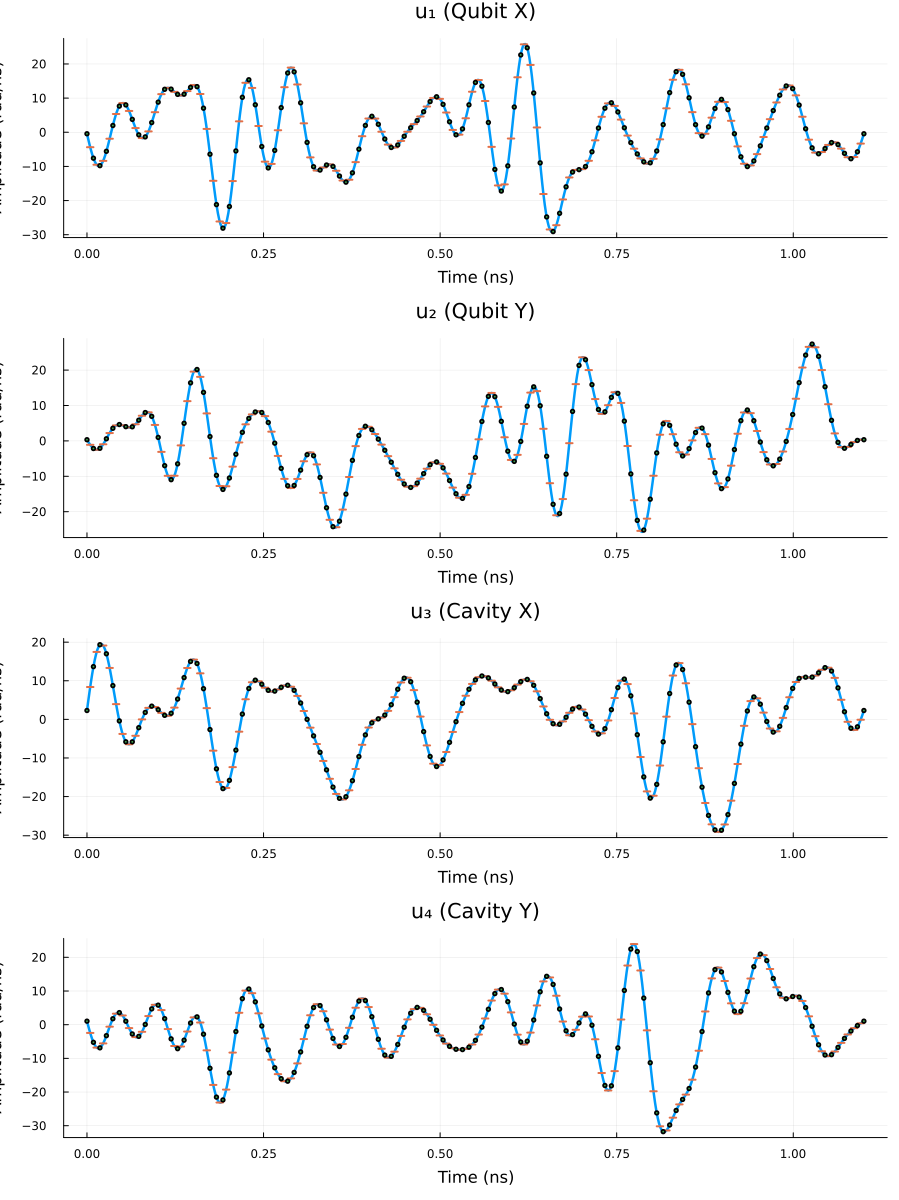

✓ Plot saved: pulses_comparison.png



(Dict{String, Any}("theta" => [-0.43632604202127506, 0.2742407118663015, -0.15695171362461233, 1.459386973224398, -0.8462878689035681, 3.141592653589793, 3.141592653589793, -2.476388729439501, -0.02759308074197698, 3.141592653589793  …  1.4515952881368006, 0.9351119581511952, -1.4172999735282366, -1.090359361657154, 3.141592653589793, -3.141592653589793, -1.770409898498322, 0.11951545947916985, -2.9209696280080286, -0.1939466731075342], "H_controls" => Matrix{ComplexF64}[[0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im], [0.0 + 0.0im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; …

In [9]:
using LinearAlgebra, Random, Optim, Plots, DifferentialEquations

# ============================================================================
# SYSTEM SETUP
# ============================================================================
function zL_minus_cavity(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-3, 4)
        k = 4n + 2
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    return ComplexF64.(ψ ./ sqrt(sum(abs2, ψ)))
end

function zL_cavitypos(alpha::Real; d_c::Int)
    ψ = zeros(BigFloat, d_c)
    for n in 0:fld(d_c-1, 4)
        k = 4n
        ψ[k+1] = BigFloat(alpha)^k / sqrt(BigFloat(factorial(big(k))))
    end
    return ComplexF64.(ψ ./ sqrt(sum(abs2, ψ)))
end

# Initialize states
α = sqrt(3)
ψ_cavidealminus = zL_minus_cavity(α; d_c=15)
ψ_cavidealpos = zL_cavitypos(α; d_c=15)
ground_state, excited_state = zeros(ComplexF64, 15), zeros(ComplexF64, 15)
ground_state[1], excited_state[2] = 1.0 + 0im, 1.0 + 0im
ψ_Zgminus = kron(ground_state[1:4], ψ_cavidealminus)
ψ_Zgpos = kron(ground_state[1:4], ψ_cavidealpos)
ψ_ground = kron(ground_state[1:4], ground_state)
ψ_excited = kron(ground_state[1:4], excited_state)

function make_system(; d_q=4, d_c=15)
    Iq, Ic = Matrix{ComplexF64}(I, d_q, d_q), Matrix{ComplexF64}(I, d_c, d_c)
    a, b = zeros(ComplexF64, d_c, d_c), zeros(ComplexF64, d_q, d_q)
    for n in 2:d_c; a[n-1, n] = sqrt(n-1) end
    for n in 2:d_q; b[n-1, n] = sqrt(n-1) end
    a⁺, b⁺ = a', b'

    H0 = (-0.0037*2π/2) * kron(Iq, a⁺*a⁺*a*a) + 
         (-236.0*2π/2) * kron(b⁺*b⁺*b*b, Ic) +
         (-2.194*2π) * kron(b⁺*b, a⁺*a) + 
         (-0.019*2π/2) * kron(b⁺*b, a⁺*a⁺*a*a)
    
    return H0, [kron(b+b⁺, Ic), kron(1im*(b⁺-b), Ic), kron(Iq, a+a⁺), kron(Iq, 1im*(a⁺-a))]
end

# ============================================================================
# FIDELITY & PULSE FUNCTIONS
# ============================================================================
fidelity_from_propagator(U) = real(abs((ψ_Zgpos)'*U*ψ_ground)^2 + abs((ψ_Zgminus)'*U*ψ_excited)^2) / 2
fidelity_from_two_states(ψ1, ψ2) = real(abs((ψ_Zgpos)'*ψ1)^2 + abs((ψ_Zgminus)'*ψ2)^2) / 2

function pulses_at_midpoints(theta, N, K; m=4)
    u_const = []
    ofs = 1
    for j in 1:m
        b0, br = theta[ofs], theta[ofs+1:ofs+K]
        push!(u_const, [b0 + sum(br[r] * sin(π * r * (k-0.5) / N) for r in 1:K) for k in 1:N])
        ofs += K + 1
    end
    return u_const
end

function coeffs_to_pulses(theta, N, K; m=4)
    t = collect(0:N)
    S = [sin.(π * r * t / N) for r in 1:K]
    u_list = []
    ofs = 1
    for j in 1:m
        b0, br = theta[ofs], theta[ofs+1:ofs+K]
        push!(u_list, b0 .+ sum(br[r] * S[r] for r in 1:K))
        ofs += K + 1
    end
    return u_list
end

# ============================================================================
# PROPAGATION
# ============================================================================
function propagate_piecewise(H0, H_controls, theta, T, N, K)
    dt = T / N
    u_const = pulses_at_midpoints(theta, N, K, m=length(H_controls))
    U = Matrix{ComplexF64}(I, size(H0, 1), size(H0, 1))
    
    for k in 1:N
        H = H0 + sum(u_const[j][k] * H_controls[j] for j in 1:length(H_controls))
        U = exp(-1im * H * dt) * U
    end
    return U
end

function solve_schrodinger_continuous(H0, H_controls, theta, T, K, ψ_init; abstol=1e-10, reltol=1e-10, maxiters=100000)
    m = length(H_controls)
    b_coeffs = [vcat(theta[j*(K+1)-K], theta[j*(K+1)-K+1:j*(K+1)]) for j in 1:m]
    
    function schrodinger!(dψ, ψ, p, t)
        H = copy(H0)
        for j in 1:m
            u_val = b_coeffs[j][1] + sum(b_coeffs[j][r+1] * sin(π * r * t / T) for r in 1:K)
            H += u_val * H_controls[j]
        end
        dψ .= -1im * H * ψ
    end
    
    prob = ODEProblem(schrodinger!, ψ_init, (0.0, T))
    sol = solve(prob, Tsit5(), abstol=abstol, reltol=reltol, dense=false, maxiters=maxiters)
    
    println("    ODE steps: $(length(sol.t)), dt: [$(minimum(diff(sol.t))), $(maximum(diff(sol.t)))]")
    return sol.u[end]
end

# ============================================================================
# OPTIMIZATION
# ============================================================================
function cost_function(theta, H0, H_controls, T, N, K; max_amp=5*pi*2, penalty_weight=1000.0)
    u_const = pulses_at_midpoints(theta, N, K, m=length(H_controls))
    penalty = sum(sum(max.(abs.(u_j) .- max_amp, 0.0).^2) for u_j in u_const)
    U = propagate_piecewise(H0, H_controls, theta, T, N, K)
    return 1.0 - fidelity_from_propagator(U) + penalty_weight * penalty
end

function run_optimization(T, N, K; seed=42, init_scale=1.0*π, maxiter=100)
    H0, H_controls = make_system()
    m = length(H_controls)
    
    Random.seed!(seed)
    theta0 = vcat([vcat(0.0, init_scale * (2*rand(K) .- 1)) for _ in 1:m]...)

    res = optimize(th -> cost_function(clamp.(th, -init_scale, init_scale), H0, H_controls, T, N, K),
                theta0, Optim.LBFGS(), Optim.Options(iterations=maxiter, f_abstol=1e-8, x_abstol=1e-8, show_trace=true))
    
    theta = clamp.(Optim.minimizer(res), -init_scale, init_scale)
    U_pw = propagate_piecewise(H0, H_controls, theta, T, N, K)
    F_pw = fidelity_from_propagator(U_pw)

    println("\n✓ Optimization Complete! Piecewise Fidelity: $F_pw")
    return Dict("theta" => theta, "u_list" => coeffs_to_pulses(theta, N, K, m=m), 
                "F_pw" => F_pw, "H0" => H0, "H_controls" => H_controls)
end

# ============================================================================
# COMPARISON
# ============================================================================
function compare_methods(opt_result, T, K; solver_abstol=1e-8, solver_reltol=1e-8, solver_maxiters=100000)
    H0, H_controls, theta = opt_result["H0"], opt_result["H_controls"], opt_result["theta"]
    F_pw = opt_result["F_pw"]
    
    println("\n✓ Solving continuous Fourier Schrödinger equation...")
    println("  1. From ψ_ground → ψ_final1")
    ψ_final1 = solve_schrodinger_continuous(H0, H_controls, theta, T, K, ψ_ground, 
                                        abstol=solver_abstol, reltol=solver_reltol, maxiters=solver_maxiters)
    println("  2. From ψ_excited → ψ_final2")
    ψ_final2 = solve_schrodinger_continuous(H0, H_controls, theta, T, K, ψ_excited, 
                                        abstol=solver_abstol, reltol=solver_reltol, maxiters=solver_maxiters)
    
    F_ode = fidelity_from_two_states(ψ_final1, ψ_final2)
    
    println("\n" * "="^70)
    println("FIDELITY COMPARISON")
    println("="^70)
    println("Piecewise (N=$K fixed steps):     F = $F_pw")
    println("Continuous Fourier (ODE):          F = $F_ode")
    println("Difference:                        $(abs(F_pw - F_ode)) ($(abs(F_pw - F_ode)/abs(F_ode)*100)%)")
    println("="^70)
    
    return Dict("F_pw" => F_pw, "F_ode" => F_ode, "diff" => abs(F_pw - F_ode))
end

# ============================================================================
# VISUALIZATION
# ============================================================================
function plot_comparison(u_list, theta, T, N, K)
    dt = T / N
    t_fourier = collect(0:N) * dt
    t_steps = [collect(0:N-1) * dt; T]
    t_fine = range(0.0, T, length=5*N)
    
    u_const = pulses_at_midpoints(theta, N, K, m=4)
    b_coeffs = [vcat(theta[j*(K+1)-K], theta[j*(K+1)-K+1:j*(K+1)]) for j in 1:4]
    u_continuous = [b_coeffs[j][1] .+ sum(b_coeffs[j][r+1] * sin.(π * r * t_fine ./ T) for r in 1:K) for j in 1:4]
    
    gr()
    labels = ["u₁ (Qubit X)", "u₂ (Qubit Y)", "u₃ (Cavity X)", "u₄ (Cavity Y)"]
    plots_array = []
    
    for idx in 1:4
        p = plot(size=(800, 300), title=labels[idx], legend=:best, grid=true)
        plot!(p, t_fine, u_continuous[idx], linewidth=2.5, label="Continuous Fourier", color=1)
        
        for k in 1:N
            plot!(p, [t_steps[k], t_steps[k+1]], [u_const[idx][k], u_const[idx][k]], 
                linewidth=2, color=2, legend=false)
        end
        plot!(p, [], [], linewidth=2, label="Piecewise-Constant", color=2)
        plot!(p, t_fourier, u_list[idx], linetype=:scatter, label="Fourier basis", color=3, markersize=2)
        
        xlabel!(p, "Time (ns)")
        ylabel!(p, "Amplitude (rad/ns)")
        push!(plots_array, p)
    end
    
    p_combined = plot(plots_array..., layout=(4, 1), size=(900, 1200))
    display(p_combined)
    savefig(p_combined, "pulses_comparison.png")
end

# ============================================================================
# MAIN
# ============================================================================
function main()
    T, N, K = 1.1, 120, 40
    
    println("\n╔════════════════════════════════════════════════════════════════════╗")
    println("║  QUANTUM CONTROL: Piecewise vs Continuous Fourier                ║")
    println("╚════════════════════════════════════════════════════════════════════╝\n")
    
    opt_result = run_optimization(T, N, K, seed=42, init_scale=1.0*π, maxiter=300)
    comparison = compare_methods(opt_result, T, K, solver_abstol=1e-8, solver_reltol=1e-8, solver_maxiters=100000)
    
    println("\n✓ Generating visualization...")
    plot_comparison(opt_result["u_list"], opt_result["theta"], T, N, K)
    println("✓ Plot saved: pulses_comparison.png\n")
    
    return opt_result, comparison
end

opt_result, comparison = main()